# Telecom Churn Case study

### Group Members:
- __Tejas Wagh(Group facilitator)__
- __Pawan Tejwani__
- __Dr.Sandeep Patil __
- __Abhishek Singh __



#### We have represented case study in the following format:
- Data Cleaning and Formatting
- EDA
- PCA and logistic regression for predicting customers who are going to churn.
- Tree models for identifying important indicators in predicting customers who are going to churn.
- Final report

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn import preprocessing
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
telecom = pd.read_csv('telecom_churn_data.csv')

In [3]:
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [5]:
print(telecom['total_rech_amt_6'].isnull().sum(),telecom['total_rech_amt_7'].isnull().sum(), telecom['total_rech_data_6'].isnull().sum(), telecom['total_rech_data_7'].isnull().sum())

(0, 0, 74846, 74428)


In [6]:
#### Imputing missing values

telecom['total_rech_data_6'].fillna(0, inplace=True)
telecom['total_rech_data_7'].fillna(0, inplace=True)
telecom['total_rech_data_8'].fillna(0, inplace=True)
telecom['total_rech_data_9'].fillna(0, inplace=True)
telecom['av_rech_amt_data_6'].fillna(0, inplace=True)
telecom['av_rech_amt_data_7'].fillna(0, inplace=True)
telecom['av_rech_amt_data_8'].fillna(0, inplace=True)
telecom['av_rech_amt_data_9'].fillna(0, inplace=True)
telecom['max_rech_data_6'].fillna(0, inplace=True)
telecom['max_rech_data_7'].fillna(0, inplace=True)
telecom['max_rech_data_8'].fillna(0, inplace=True)
telecom['max_rech_data_9'].fillna(0, inplace=True)


telecom['night_pck_user_6'].fillna(-1, inplace=True)
telecom['night_pck_user_7'].fillna(-1, inplace=True)
telecom['night_pck_user_8'].fillna(-1, inplace=True)
telecom['night_pck_user_9'].fillna(-1, inplace=True)
telecom['fb_user_6'].fillna(-1, inplace=True)
telecom['fb_user_7'].fillna(-1, inplace=True)
telecom['fb_user_8'].fillna(-1, inplace=True)
telecom['fb_user_9'].fillna(-1, inplace=True)

In [7]:
telecom['total_rech_amt_data_6'] = telecom['total_rech_data_6'] * telecom['av_rech_amt_data_6']
telecom['total_rech_amt_data_7'] = telecom['total_rech_data_7'] * telecom['av_rech_amt_data_7']
telecom['total_rech_amt_data_8'] = telecom['total_rech_data_8'] * telecom['av_rech_amt_data_8']
telecom['total_rech_amt_data_9'] = telecom['total_rech_data_9'] * telecom['av_rech_amt_data_9']

In [8]:
#As per problem statement creating a column of average recharge amount of first two months
telecom['avg_rech_amt'] = ((telecom['total_rech_amt_6'] + telecom['total_rech_amt_data_6']) + (telecom['total_rech_amt_7'] + telecom['total_rech_amt_data_7']))/2

##### As per problem statement creating dataframe which has only customers with average recharge amount more than or equal to 70th percentile of average recharge amount 


In [9]:
Q = telecom.avg_rech_amt.quantile(0.7)

In [10]:
telecom = telecom[telecom.avg_rech_amt >= Q]

In [11]:
telecom.shape

(30001, 231)

In [12]:
telecom['churn'] = np.where(((telecom['total_ic_mou_9']==0) & (telecom['total_og_mou_9']==0)) & ((telecom['vol_2g_mb_9']==0) & (telecom['vol_3g_mb_9']==0)),1,0)

In [13]:
telecom['churn'].value_counts()

0    27560
1     2441
Name: churn, dtype: int64

In [14]:
#dropping columns with '_9' at the end
new_col = [c for c in telecom.columns if c[-2:] != '_9']
telecom = telecom[new_col]

In [15]:
# Checking percentage missing values in each columns
100*(telecom.isnull().sum()/len(telecom.index))

mobile_number             0.000000
circle_id                 0.000000
loc_og_t2o_mou            0.746642
std_og_t2o_mou            0.746642
loc_ic_t2o_mou            0.746642
last_date_of_month_6      0.000000
last_date_of_month_7      0.089997
last_date_of_month_8      0.549982
arpu_6                    0.000000
arpu_7                    0.000000
arpu_8                    0.000000
onnet_mou_6               1.816606
onnet_mou_7               1.789940
onnet_mou_8               3.913203
offnet_mou_6              1.816606
offnet_mou_7              1.789940
offnet_mou_8              3.913203
roam_ic_mou_6             1.816606
roam_ic_mou_7             1.789940
roam_ic_mou_8             3.913203
roam_og_mou_6             1.816606
roam_og_mou_7             1.789940
roam_og_mou_8             3.913203
loc_og_t2t_mou_6          1.816606
loc_og_t2t_mou_7          1.789940
loc_og_t2t_mou_8          3.913203
loc_og_t2m_mou_6          1.816606
loc_og_t2m_mou_7          1.789940
loc_og_t2m_mou_8    

In [16]:
max(100*(telecom.isnull().sum()/len(telecom.index)))

46.82510582980567

In [17]:
#dropping columns which have more than 50% NaN values
for cl in telecom.columns:
    if 100*(telecom[cl].isnull().sum()/len(telecom[cl].index)) > 40:
        telecom = telecom.drop(cl, axis=1)

In [18]:
100*(telecom.isnull().sum()/len(telecom.index))

mobile_number             0.000000
circle_id                 0.000000
loc_og_t2o_mou            0.746642
std_og_t2o_mou            0.746642
loc_ic_t2o_mou            0.746642
last_date_of_month_6      0.000000
last_date_of_month_7      0.089997
last_date_of_month_8      0.549982
arpu_6                    0.000000
arpu_7                    0.000000
arpu_8                    0.000000
onnet_mou_6               1.816606
onnet_mou_7               1.789940
onnet_mou_8               3.913203
offnet_mou_6              1.816606
offnet_mou_7              1.789940
offnet_mou_8              3.913203
roam_ic_mou_6             1.816606
roam_ic_mou_7             1.789940
roam_ic_mou_8             3.913203
roam_og_mou_6             1.816606
roam_og_mou_7             1.789940
roam_og_mou_8             3.913203
loc_og_t2t_mou_6          1.816606
loc_og_t2t_mou_7          1.789940
loc_og_t2t_mou_8          3.913203
loc_og_t2m_mou_6          1.816606
loc_og_t2m_mou_7          1.789940
loc_og_t2m_mou_8    

In [19]:
null_4=[]
for cl in telecom.columns:
    if 2<100*(telecom[cl].isnull().sum()/len(telecom[cl].index))<5 :
        null_4.append(cl)
# null_4 is the list of columns with 4% missing values 

In [20]:
null_4

[]

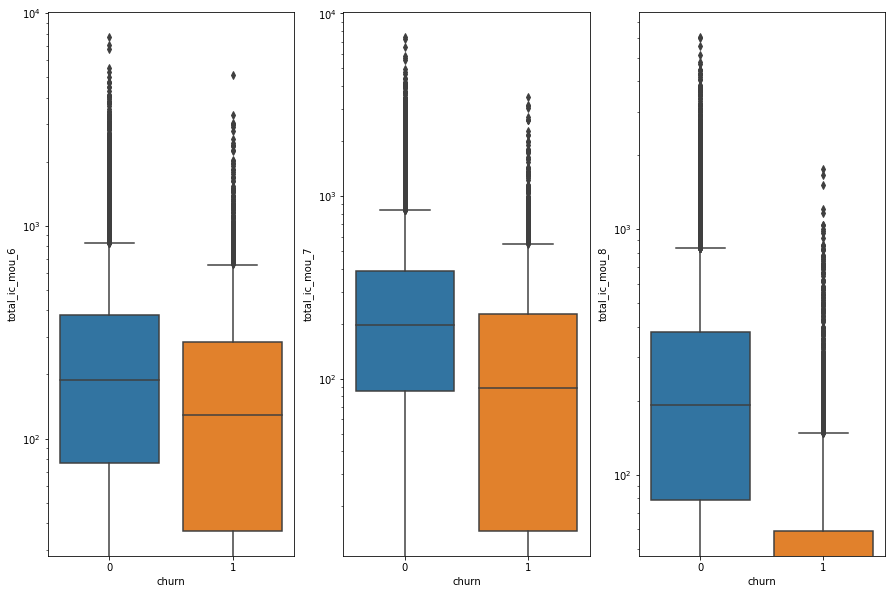

In [21]:
## Let's see minutes of usage boxplots for total_ic_mou_6
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_ic_mou_6', data=telecom)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_ic_mou_7', data=telecom)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_ic_mou_8', data=telecom)
plt.yscale('log')


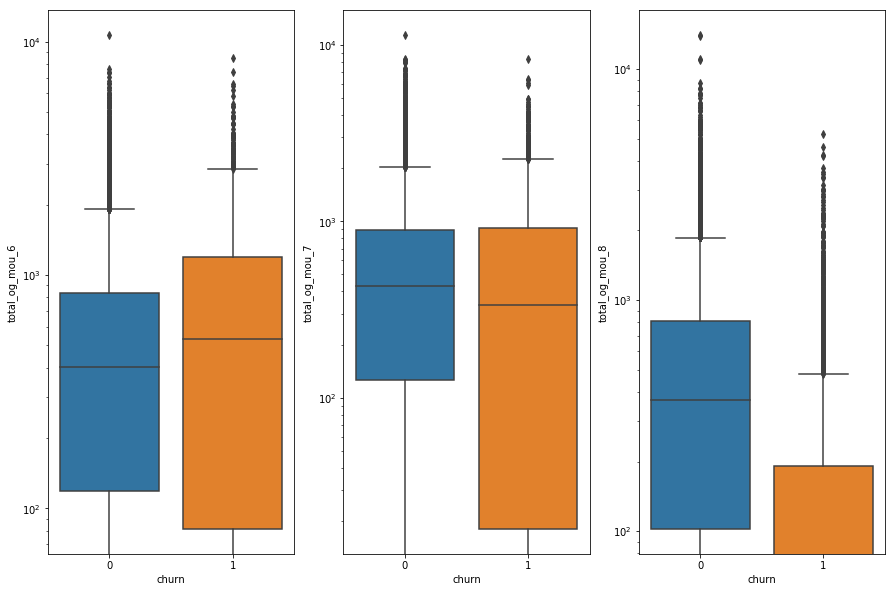

In [22]:
## Let's see minutes of usage boxplots for total_og_mou_6
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_og_mou_6', data=telecom)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_og_mou_7', data=telecom)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_og_mou_8', data=telecom)
plt.yscale('log')


- All the columns with 4 percent missing values are from 8th month(_8 at the end). 
- From the boxplot above those who are going to churn in 9th month, there is significant drop in total_ic_mou_8 and total_og_mou_8.Which implies customers have stopped getting any type of incoming or outgoing calls.
- Therefore in the columns with _mou_8 at the end we can impute 0 for null values.

In [23]:
for nl in null_4:
    telecom[nl].fillna(0, inplace=True)

In [24]:
max(100*(telecom.isnull().sum()/len(telecom.index)))

46.82510582980567

In [25]:
#Dropping rows with missing values
telecom= telecom.dropna(axis=0)

In [26]:
# All of the object datatype columns are of dates. We are dropping those here
obj_col =telecom.select_dtypes(include=['object']).columns
obj_col

Index([u'last_date_of_month_6', u'last_date_of_month_7',
       u'last_date_of_month_8', u'date_of_last_rech_6', u'date_of_last_rech_7',
       u'date_of_last_rech_8', u'date_of_last_rech_data_6',
       u'date_of_last_rech_data_7', u'date_of_last_rech_data_8'],
      dtype='object')

In [27]:
## Formatting columns which have date in them
for oc in obj_col:
    telecom[oc]= pd.to_datetime(telecom[oc],format = "%m/%d/%Y")
## Removing month and year and only keeping date(day of the month) as month is already captured in columns name
telecom['last_day_of_month_6'] = telecom['last_date_of_month_6'].dt.day
telecom['last_day_of_month_7'] = telecom['last_date_of_month_7'].dt.day
telecom['last_day_of_month_8'] = telecom['last_date_of_month_8'].dt.day
telecom['day_of_last_rech_6'] = telecom['date_of_last_rech_6'].dt.day
telecom['day_of_last_rech_7'] = telecom['date_of_last_rech_7'].dt.day
telecom['day_of_last_rech_8'] = telecom['date_of_last_rech_8'].dt.day

In [28]:
telecom= telecom.drop(obj_col, axis=1)

In [29]:
# creating separate dataframe for categorical variables
cat_list= ['night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8']
telecom_categorical= telecom[cat_list]
telecom_categorical.head()

,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8
33,1.0,1.0,0.0,1.0,1.0,1.0
53,0.0,0.0,0.0,1.0,0.0,0.0
56,0.0,0.0,0.0,1.0,1.0,1.0
57,0.0,0.0,0.0,1.0,1.0,1.0
61,0.0,0.0,0.0,1.0,1.0,1.0


In [30]:
# creating another dataframe for numerical variables
telecom_numerical = telecom.drop(cat_list, axis=1)
telecom_numerical = telecom_numerical.drop('churn', axis= 1)

In [31]:
telecom_numerical.nunique().sort_values(ascending=True)

std_ic_t2o_mou_6           1
std_og_t2c_mou_8           1
std_ic_t2o_mou_7           1
std_ic_t2o_mou_8           1
std_og_t2c_mou_7           1
last_day_of_month_6        1
last_day_of_month_7        1
std_og_t2c_mou_6           1
circle_id                  1
loc_og_t2o_mou             1
std_og_t2o_mou             1
last_day_of_month_8        1
loc_ic_t2o_mou             1
monthly_2g_6               5
monthly_2g_7               6
monthly_2g_8               6
monthly_3g_6              12
monthly_3g_8              12
monthly_3g_7              15
count_rech_3g_6           25
sachet_3g_6               25
sachet_3g_7               26
count_rech_3g_7           27
count_rech_3g_8           29
day_of_last_rech_7        29
sachet_3g_8               29
day_of_last_rech_6        29
count_rech_2g_6           31
sachet_2g_6               31
day_of_last_rech_8        31
                       ...  
loc_og_t2m_mou_7        7703
loc_og_t2m_mou_6        7759
loc_og_t2m_mou_8        7774
vol_3g_mb_7   

In [32]:
#To capture maximum variance let's drop the columns which have only one value in them
telecom_numerical = telecom_numerical.loc[:,telecom.apply(pd.Series.nunique) >1]

In [33]:
telecom_numerical.shape

(11646, 154)

In [34]:
numeric_col= telecom_numerical.columns

In [35]:
telecom_categorical.shape

(11646, 6)

In [36]:
main_frame = pd.concat([telecom_numerical,telecom_categorical, telecom['churn']], axis=1)
main_frame.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,churn
33,7000149764,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,...,30,30,26,1.0,1.0,0.0,1.0,1.0,1.0,0
53,7002188521,978.077,1141.296,706.020,135.14,119.59,102.69,479.31,543.18,261.34,...,29,31,26,0.0,0.0,0.0,1.0,0.0,0.0,0
56,7002180748,452.624,320.548,368.807,34.46,43.11,50.61,131.59,90.61,84.31,...,28,30,31,0.0,0.0,0.0,1.0,1.0,1.0,0
57,7001682585,1201.298,687.704,602.052,61.23,7.39,62.89,165.41,211.31,168.01,...,29,26,24,0.0,0.0,0.0,1.0,1.0,1.0,0
61,7000152517,565.516,390.307,430.911,178.41,226.81,170.11,186.68,45.08,145.08,...,28,29,23,0.0,0.0,0.0,1.0,1.0,1.0,0


In [37]:
main_frame['churn'].value_counts()

0    11401
1      245
Name: churn, dtype: int64

# EDA
#### Here we're aiming to understand behaviour and recognize pattern of churners before they churned


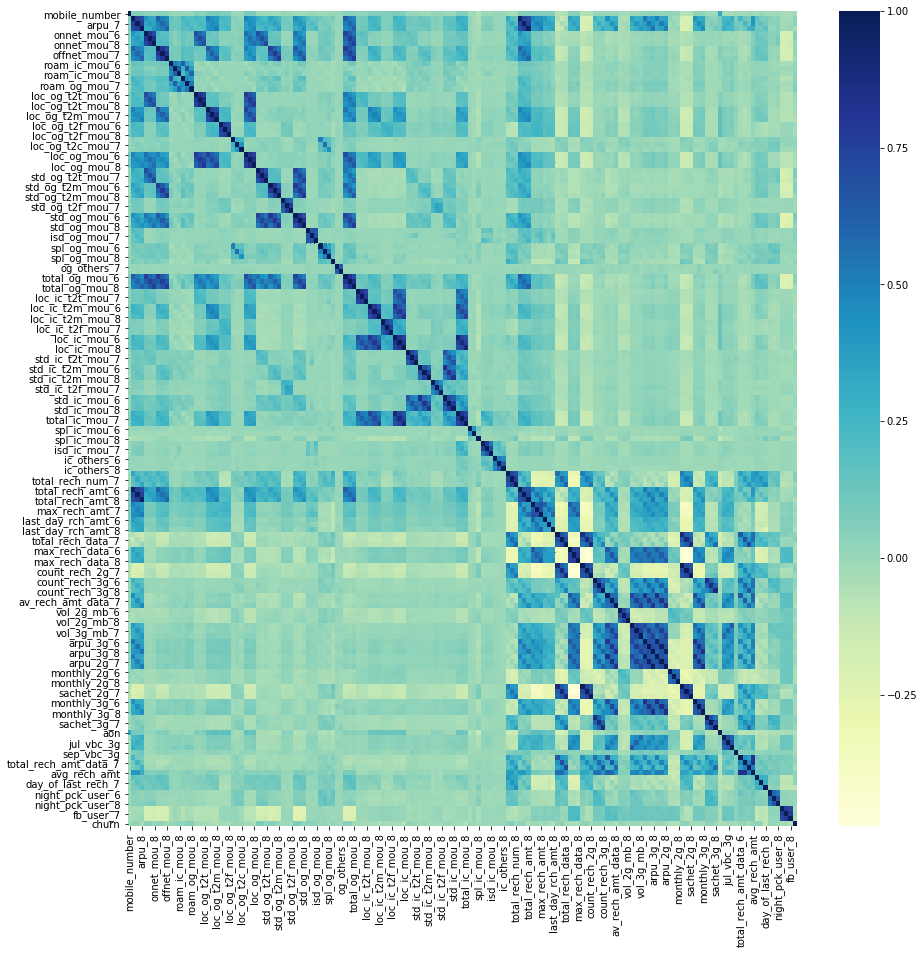

In [38]:
## Lets see the correlation matrix first

# figure size
plt.figure(figsize=(15,15))

# heatmap
sns.heatmap(main_frame.corr(), cmap="YlGnBu")
plt.show()


- Since the feature space is too large it is very difficult to analyse the correlation matrix above

### Analysis of different recharge and data usage
- Analysis of avg_rech_amt_6/7/8

In [39]:
main_frame.pivot_table(values = 'avg_rech_amt',
                      index = 'churn', 
                      aggfunc = 'mean')

,avg_rech_amt
churn,
0,1557.122798
1,1871.130612


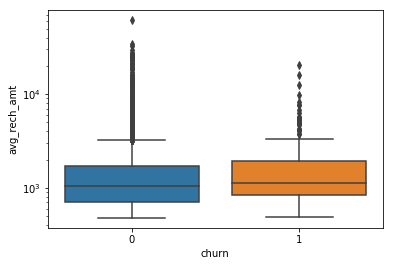

In [40]:
sns.boxplot(x='churn', y='avg_rech_amt', data=main_frame)
plt.yscale('log')

- let's analyse last_day_rch_amt6/7/8

In [41]:
main_frame.pivot_table(values = ['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8
churn,,,
0,91.005964,91.805105,92.533023
1,88.436735,77.175510,43.514286


- There is significant drop in mean last_day_rch_amt_8 for the churners who are going to churn

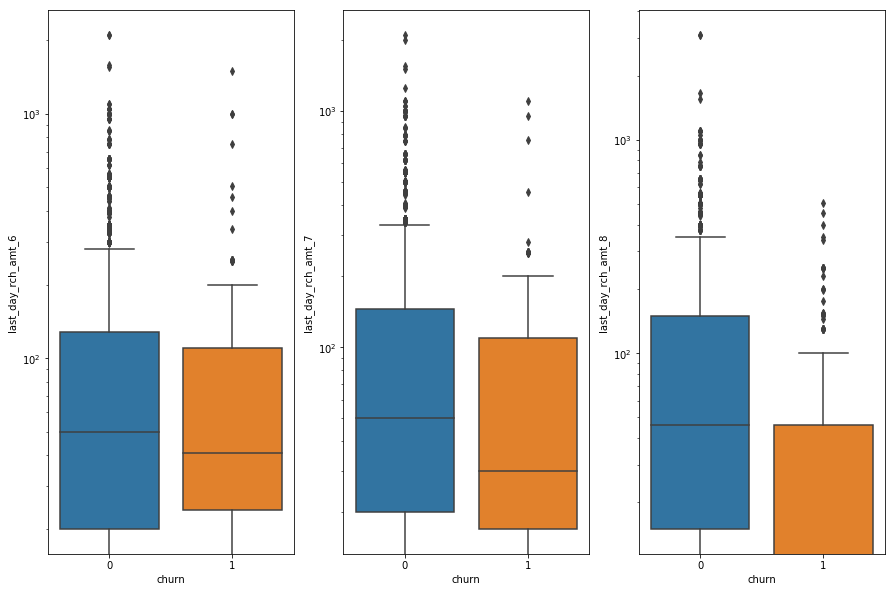

In [42]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='last_day_rch_amt_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='last_day_rch_amt_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='last_day_rch_amt_8', data=main_frame)
plt.yscale('log')


- let's analyse __total_rch_data_6/7/8__

In [43]:
main_frame.pivot_table(values = ['total_rech_data_6','total_rech_data_7','total_rech_data_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,total_rech_data_6,total_rech_data_7,total_rech_data_8
churn,,,
0,3.22577,3.566266,3.352250
1,4.02449,4.795918,2.742857


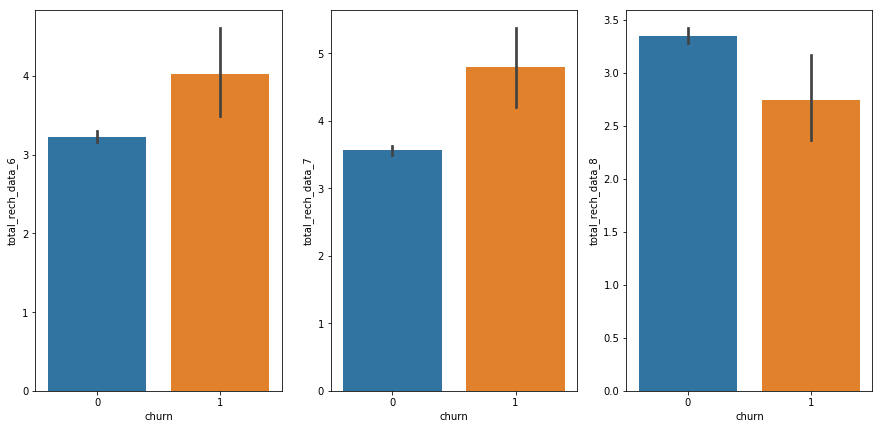

In [44]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='total_rech_data_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='total_rech_data_7', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='total_rech_data_8', data=main_frame)
# plt.yscale('log')

In [45]:
main_frame[['total_rech_data_6','total_rech_data_7','total_rech_data_8']].describe()

,total_rech_data_6,total_rech_data_7,total_rech_data_8
count,11646.000000,11646.000000,11646.00000
mean,3.242573,3.592135,3.33943
std,3.486707,3.789895,3.82048
min,1.000000,1.000000,1.00000
25%,1.000000,1.000000,1.00000
50%,2.000000,2.000000,2.00000
75%,4.000000,5.000000,4.00000
max,61.000000,54.000000,60.00000


- __av_rech_amt_data__ analysis 

In [46]:
main_frame.pivot_table(values = ['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8
churn,,,
0,242.002958,258.767977,248.538744
1,205.468000,246.474816,161.493184


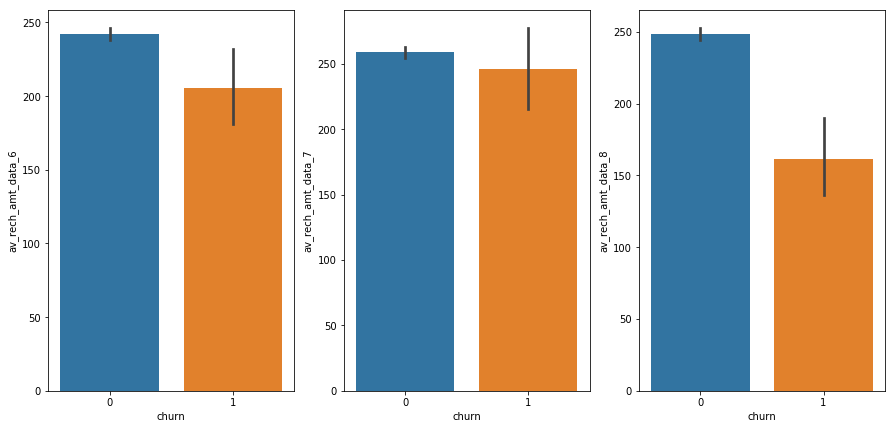

In [47]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='av_rech_amt_data_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='av_rech_amt_data_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='av_rech_amt_data_8', data=main_frame)
# plt.yscale('log')


- total rech_amt_data_6/7/8

In [48]:
main_frame.pivot_table(values = ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8
churn,,,
0,914.170130,1058.923725,1012.548331
1,1019.383347,1405.955429,559.822694


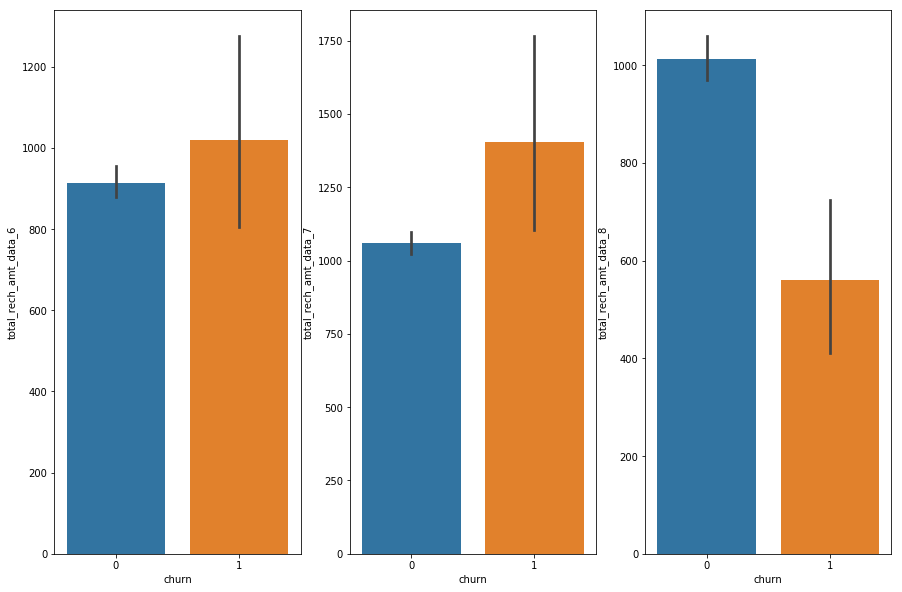

In [49]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='total_rech_amt_data_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='total_rech_amt_data_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='total_rech_amt_data_8', data=main_frame)
# plt.yscale('log')


- __vol_3g_mb__ analysis

In [50]:
main_frame.pivot_table(values = ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
churn,,,
0,659.50250,720.974828,730.042928
1,600.67249,709.387551,438.067918


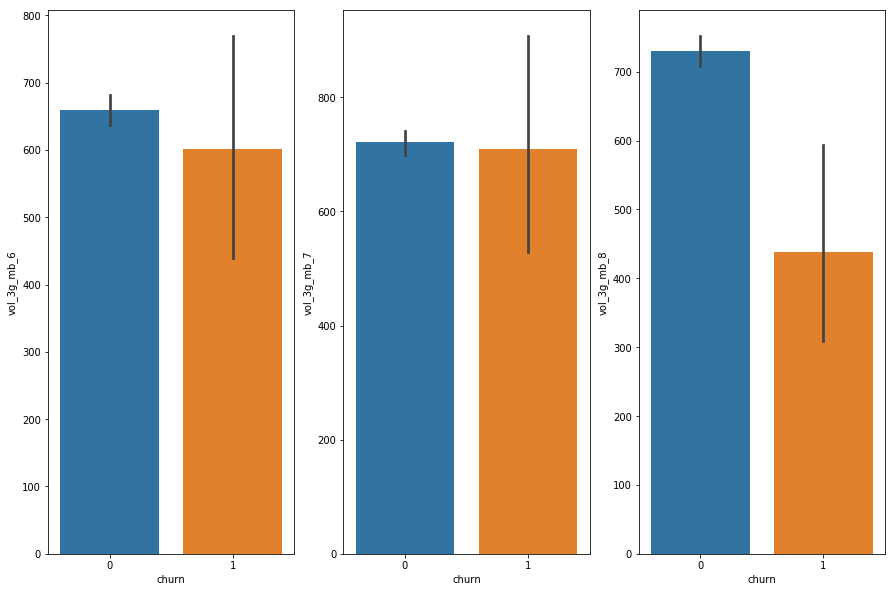

In [51]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='vol_3g_mb_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='vol_3g_mb_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='vol_3g_mb_8', data=main_frame)
# plt.yscale('log')


- __max_rech_data_6/7/8__ analysis

In [52]:
main_frame.pivot_table(values = ['max_rech_data_6','max_rech_data_7','max_rech_data_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,max_rech_data_6,max_rech_data_7,max_rech_data_8
churn,,,
0,137.589597,140.690992,141.485045
1,107.808163,119.506122,100.085714


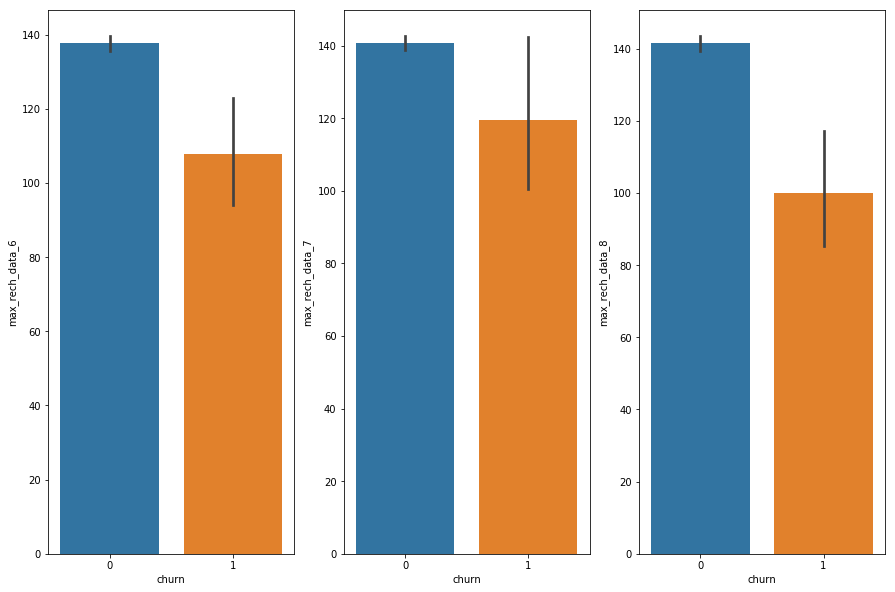

In [53]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='max_rech_data_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='max_rech_data_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='max_rech_data_8', data=main_frame)
# plt.yscale('log')


- __max_rech_data_6/7/8__ analysis

In [54]:
main_frame.pivot_table(values = ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
churn,,,
0,167.357249,170.914832,172.639768
1,151.608163,169.991837,149.163265


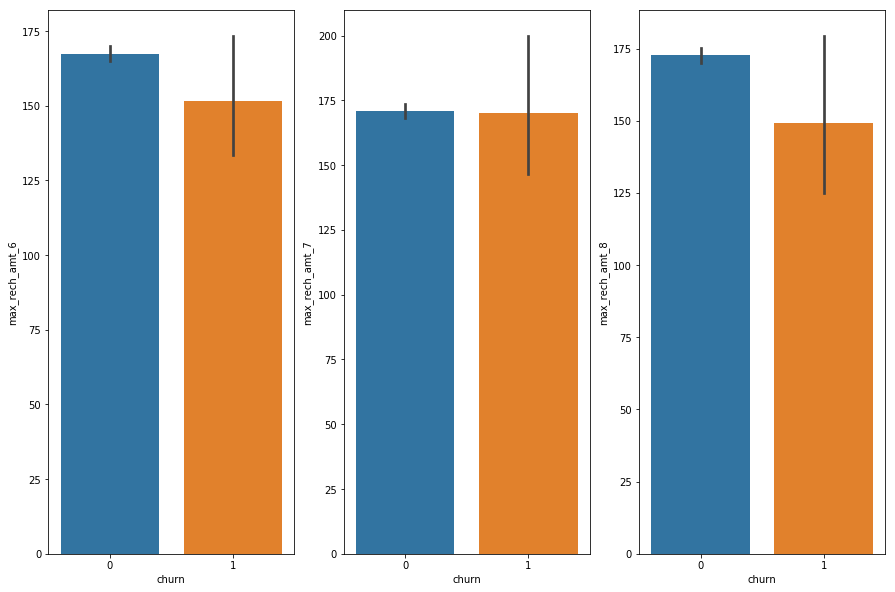

In [55]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='max_rech_amt_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='max_rech_amt_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='max_rech_amt_8', data=main_frame)
# plt.yscale('log')


### Analysis of _Minutes of Usage_

- let's analyse __total_ic_mou_6/7/8__

In [56]:
main_frame.pivot_table(values = ['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
churn,,,
0,293.051340,303.600565,302.067821
1,225.552531,235.506122,144.256041


- There is significant drop in mean __total_ic_mou_8__ for the churners who are going to churn

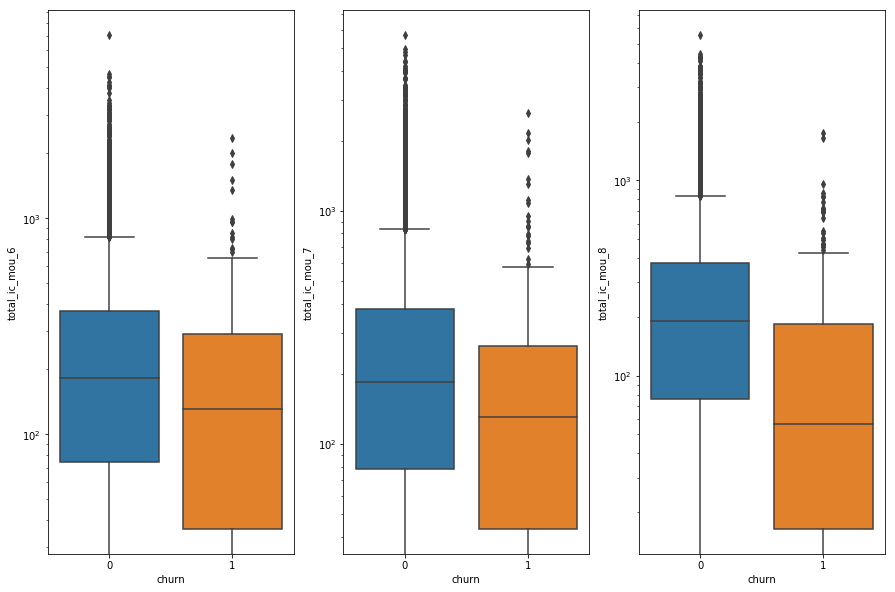

In [57]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_ic_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_ic_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_ic_mou_8', data=main_frame)
plt.yscale('log')


- let's analyse __total_og_mou_6/7/8__

In [58]:
main_frame.pivot_table(values = ['total_og_mou_6','total_og_mou_7','total_og_mou_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,total_og_mou_6,total_og_mou_7,total_og_mou_8
churn,,,
0,362.307299,372.493605,364.726483
1,525.205020,516.399673,288.686980


- There is significant drop in mean __total_og_mou_8__ for the churners who are going to churn

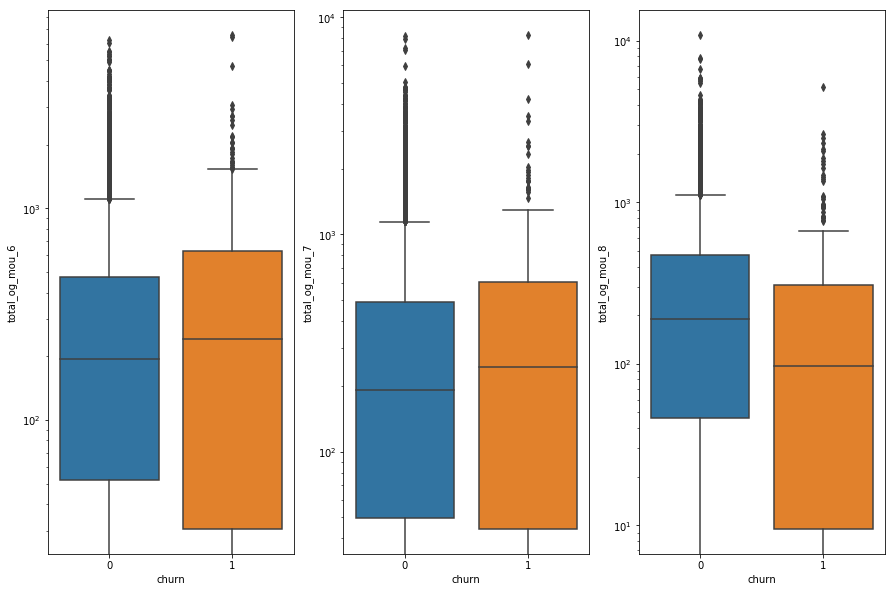

In [59]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_og_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_og_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_og_mou_8', data=main_frame)
plt.yscale('log')


- Above we saw significant drop in total minutes of usage variable in 8th month compare to what it wqas in 6th and 7th month. 
- Let's break it down further in roaming and local minutes of usage and see what we can find:

- let's analyse __roam_og_mou_6/7/8 and roam_ic_mou_6/7/8__

In [60]:
main_frame.pivot_table(values = ['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8
churn,,,
0,15.323838,10.650434,11.913729
1,28.234327,28.340735,43.494735


In [61]:
main_frame.pivot_table(values = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8'],
                      index = 'churn', 
                      aggfunc = 'mean')

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8
churn,,,
0,12.087805,9.152841,10.274731
1,14.465551,16.353143,26.894082


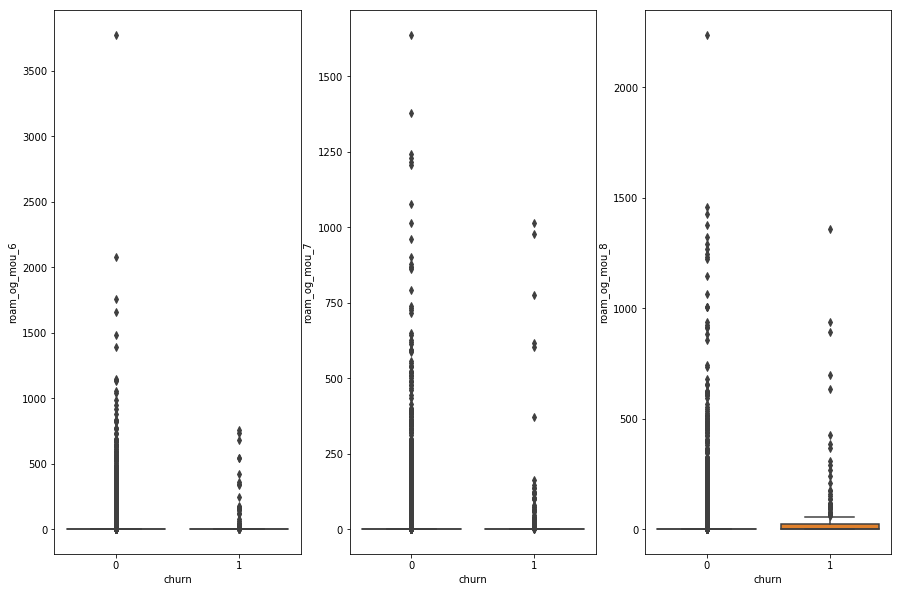

In [62]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='roam_og_mou_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='roam_og_mou_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='roam_og_mou_8', data=main_frame)
# plt.yscale('log')


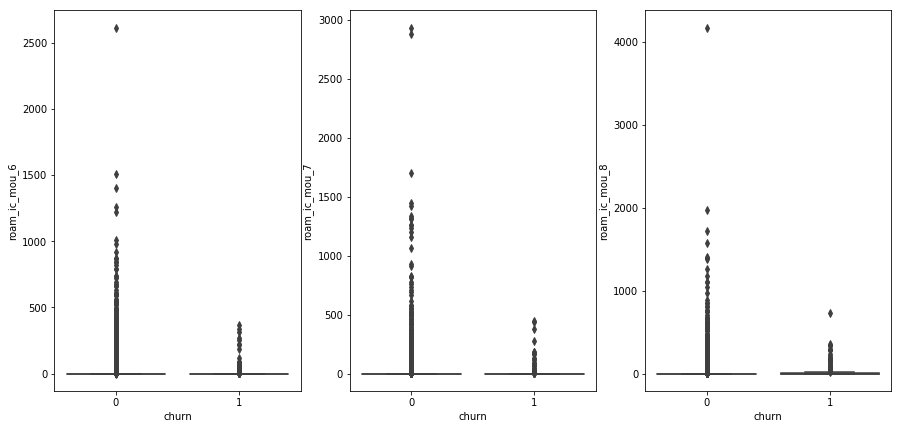

In [63]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='roam_ic_mou_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='roam_ic_mou_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='roam_ic_mou_8', data=main_frame)
# plt.yscale('log')


- Let's see of loc_og/ic_mou explains anything

In [64]:
main_frame.pivot_table(values= ['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8'],
                       index= 'churn',
                      aggfunc= 'mean')

,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8
churn,,,
0,220.297438,221.407227,217.505878
1,164.483918,158.560980,100.933755


In [65]:
main_frame.pivot_table(values= ['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8'],
                       index= 'churn',
                      aggfunc= 'mean')

,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8
churn,,,
0,239.452842,245.231200,245.737839
1,165.629714,168.590449,107.314122


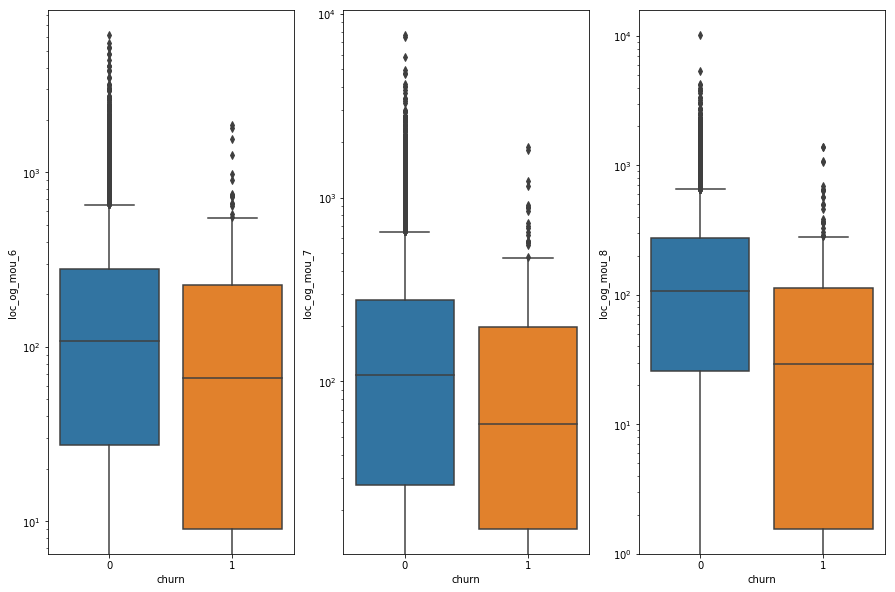

In [66]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='loc_og_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='loc_og_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='loc_og_mou_8', data=main_frame)
plt.yscale('log')


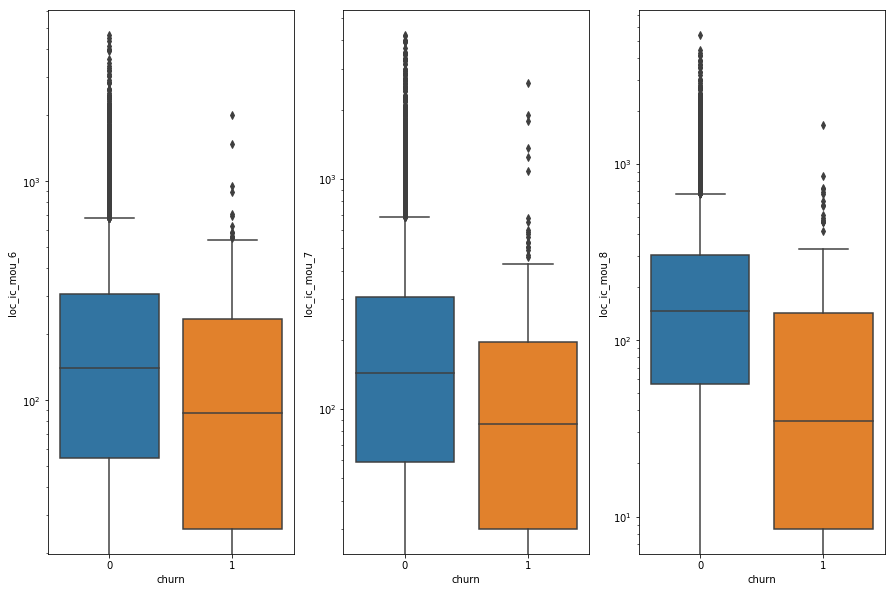

In [67]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='loc_ic_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='loc_ic_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='loc_ic_mou_8', data=main_frame)
plt.yscale('log')


- Analysis of isd_og_mou

In [68]:
main_frame.pivot_table(values= ['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8'],
                      index='churn',
                      aggfunc= 'mean')

,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8
churn,,,
0,0.841108,0.947288,0.897336
1,3.326980,4.645796,3.990286


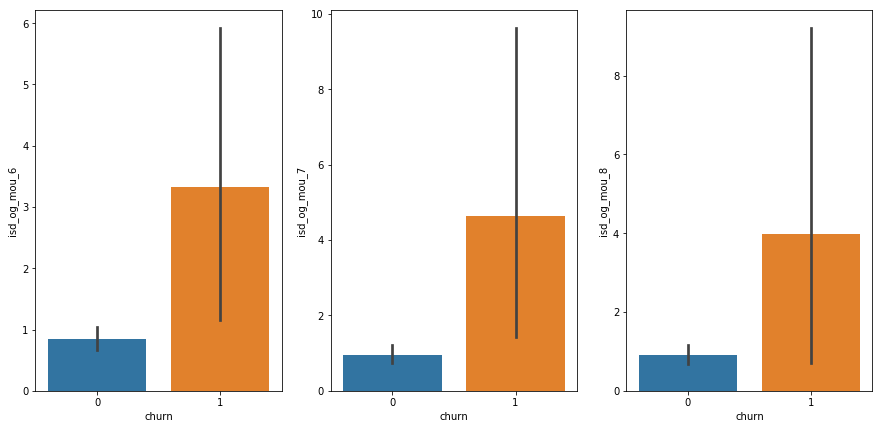

In [69]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='isd_og_mou_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='isd_og_mou_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='isd_og_mou_8', data=main_frame)
# plt.yscale('log')


- Analysis of isd_ic_mou

In [70]:
main_frame.pivot_table(values= ['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8'],
                     index= 'churn',
                      aggfunc= 'mean')

,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8
churn,,,
0,11.472173,12.028756,11.664679
1,12.319551,15.622204,8.273102


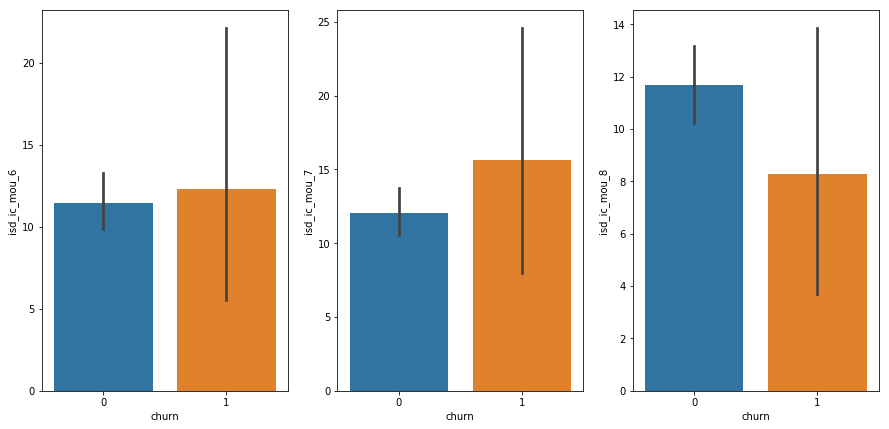

In [71]:
plt.figure(figsize=(15,7))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='isd_ic_mou_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='isd_ic_mou_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='isd_ic_mou_8', data=main_frame)
# plt.yscale('log')


In [72]:
main_frame[['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8','isd_og_mou_6','isd_og_mou_7','isd_og_mou_8']].describe()

,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8
count,11646.000000,11646.000000,11646.000000,11646.000000,11646.000000,11646.000000
mean,11.490000,12.104353,11.593329,0.893404,1.025094,0.962403
std,96.690164,95.202161,79.611482,10.564013,13.515520,13.411088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6789.410000,4747.910000,3432.880000,360.160000,643.660000,555.710000


- std_og_mou_6/7/8

In [73]:
main_frame.pivot_table(values=['std_og_mou_6','std_og_mou_7','std_og_mou_8'],
                      index= 'churn',
                      aggfunc= 'mean')

,std_og_mou_6,std_og_mou_7,std_og_mou_8
churn,,,
0,135.456746,144.206542,140.299500
1,350.228367,345.298531,179.557061


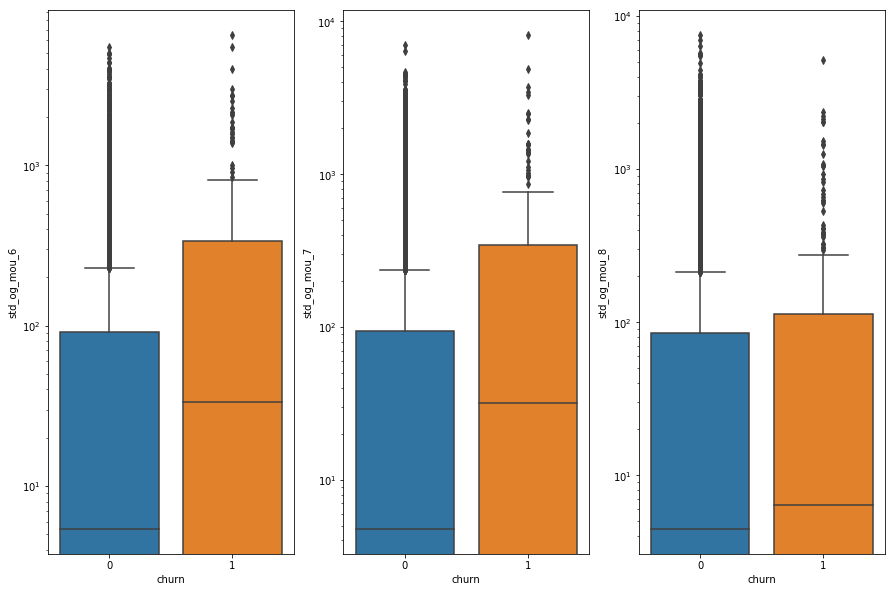

In [74]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='std_og_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='std_og_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='std_og_mou_8', data=main_frame)
plt.yscale('log')


- std_ic_mou_6/7/8

In [75]:
main_frame.pivot_table(values=['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8'],
                      index= 'churn',
                      aggfunc= 'mean')

,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8
churn,,,
0,40.997794,44.869525,43.445371
1,46.874000,50.099102,27.785306


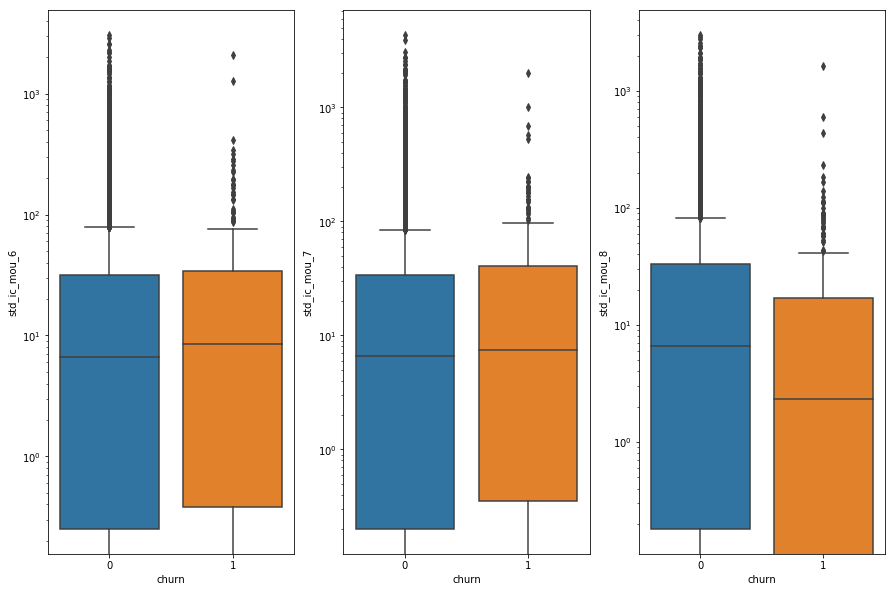

In [76]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='std_ic_mou_6', data=main_frame)
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='std_ic_mou_7', data=main_frame)
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='std_ic_mou_8', data=main_frame)
plt.yscale('log')


### Analysis of _Average revenue per user_

In [77]:
main_frame.pivot_table(values=['arpu_6','arpu_7','arpu_8'],
                      index= 'churn',
                      aggfunc= 'mean')

,arpu_6,arpu_7,arpu_8
churn,,,
0,487.143731,493.497179,489.679101
1,552.059559,571.191498,384.587996


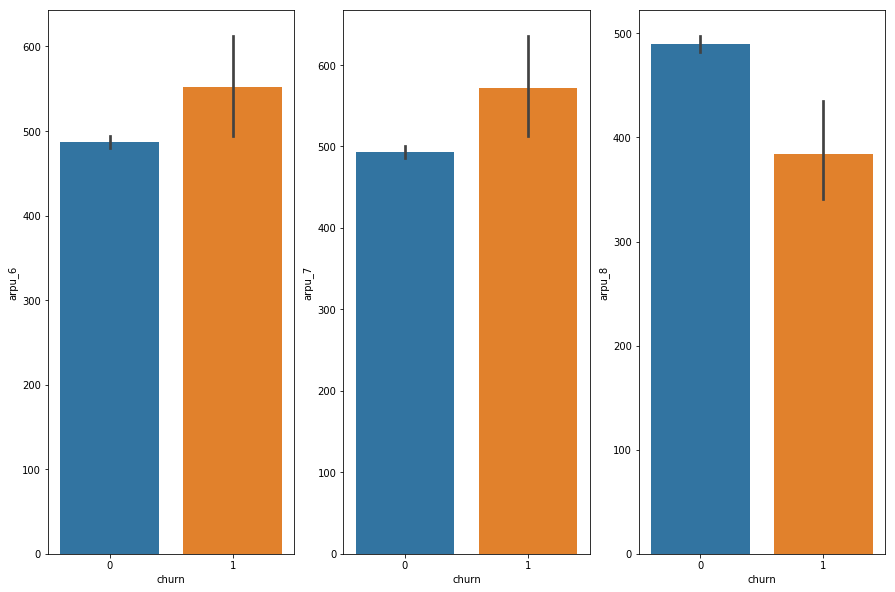

In [78]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
sns.barplot(x='churn', y='arpu_6', data=main_frame)
# plt.yscale('log')

plt.subplot(1, 3, 2)
sns.barplot(x='churn', y='arpu_7', data=main_frame)
# plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(x='churn', y='arpu_8', data=main_frame)
# plt.yscale('log')


#### Let's also look at the distribution of day of last recharge

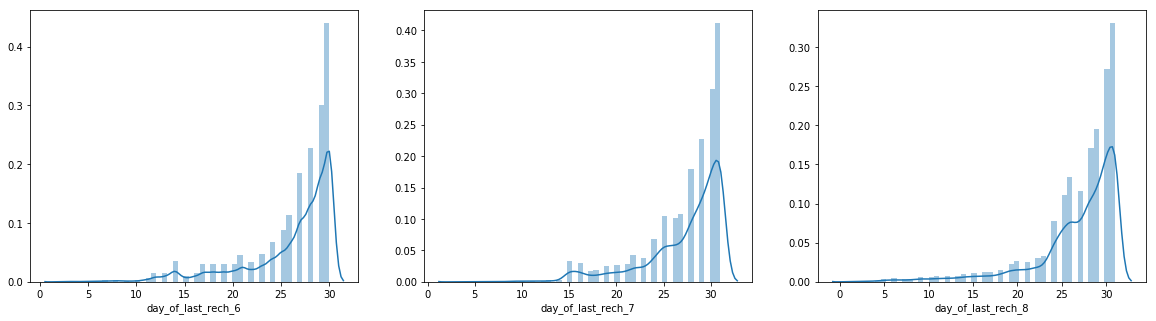

In [79]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
sns.distplot(main_frame['day_of_last_rech_6'])
plt.subplot(1, 3, 2)
sns.distplot(main_frame['day_of_last_rech_7'])
plt.subplot(1, 3, 3)
sns.distplot(main_frame['day_of_last_rech_8'])

In [80]:
main_frame.groupby(['churn','day_of_last_rech_6'])['mobile_number'].count()

churn  day_of_last_rech_6
0      2                        4
       3                        8
       4                        6
       5                       10
       6                       10
       7                       17
       8                       23
       9                       14
       10                      17
       11                      39
       12                      97
       13                     100
       14                     235
       15                      68
       16                      98
       17                     194
       18                     191
       19                     193
       20                     197
       21                     291
       22                     222
       23                     303
       24                     438
       25                     563
       26                     719
       27                    1194
       28                    1449
       29                    1902
       30             

In [81]:
main_frame.groupby(['churn','day_of_last_rech_7'])['mobile_number'].count()

churn  day_of_last_rech_7
0      3                        2
       4                        2
       5                        2
       6                        3
       7                        5
       8                        4
       9                       14
       10                      13
       11                      11
       12                      14
       13                      18
       14                      19
       15                     207
       16                     192
       17                     115
       18                     117
       19                     165
       20                     174
       21                     182
       22                     277
       23                     251
       24                     432
       25                     664
       26                     653
       27                     687
       28                    1147
       29                    1455
       30                    1956
       31             

In [82]:
main_frame.groupby(['churn','day_of_last_rech_8'])['mobile_number'].count()

churn  day_of_last_rech_8
0      1                        5
       2                        6
       3                        8
       4                       11
       5                       22
       6                       27
       7                       23
       8                       26
       9                       47
       10                      39
       11                      49
       12                      50
       13                      54
       14                      72
       15                      78
       16                      79
       17                      88
       18                     103
       19                     155
       20                     178
       21                     173
       22                     202
       23                     226
       24                     525
       25                     752
       26                     893
       27                     805
       28                    1175
       29             

# Model Building


In [83]:
## Seperating independent variables and target variables
X = main_frame.drop(['mobile_number','churn'], axis=1)
y = main_frame[['churn']]

In [84]:
##Creating another copy for logistic regression as it needs scaled data and ree models don't
Xl= copy.copy(X)
yl= copy.copy(y)

In [85]:
print(X.shape)
print(y.shape)

(11646, 159)
(11646, 1)


### Logistic Regression

In [86]:
### standardising the data.
### Since Xl is copy of X we can use it in the following way so that we don't end up losing name of the columns.
Xl = (X-X.mean())/X.std()

For each category (level) of a categorical variable, computing the churn rate (i.e. no. of churn/non-churn + churn), which will be a number (fraction) and replacing each categorical level with this number. 


In [87]:
# computing the churn rate
npu_6 = main_frame.groupby('night_pck_user_6')['churn'].mean()
npu_7 = main_frame.groupby('night_pck_user_7')['churn'].mean()
npu_8 = main_frame.groupby('night_pck_user_8')['churn'].mean()

fbu_6 = main_frame.groupby('fb_user_6')['churn'].mean()
fbu_7 = main_frame.groupby('fb_user_7')['churn'].mean()
fbu_8 = main_frame.groupby('fb_user_8')['churn'].mean()

In [88]:
npu_6

night_pck_user_6
0.0    0.020756
1.0    0.032609
Name: churn, dtype: float64

In [89]:
# creating dictionaries cosnsisting of churn rate for categories
np6= npu_6.to_dict()
np7= npu_7.to_dict()
np8= npu_8.to_dict()

fb6= fbu_6.to_dict()
fb7= fbu_7.to_dict()
fb8= fbu_8.to_dict()

In [90]:
# changing the categorical colummn values by the map created in the dictionaries above
Xl= Xl.replace({"night_pck_user_6": np6})
Xl= Xl.replace({"night_pck_user_7": np7})
Xl= Xl.replace({"night_pck_user_8": np8})
Xl= Xl.replace({"fb_user_6": fb6})
Xl= Xl.replace({"fb_user_7": fb7})
Xl= Xl.replace({"fb_user_8": fb8})

In [91]:
# splitting data into training and tesing sets
Xl_train, Xl_test, yl_train, yl_test= train_test_split(Xl, yl, train_size= 0.7, test_size= 0.3, random_state= 100)

In [92]:
#Percentage churner in training data set
yl_train[yl_train['churn']==1].count()/yl_train['churn'].count() * 100

churn    1.999509
dtype: float64

- In training data set the churning rate is 6.77. This rate is very low and can lead to very high bias.
- To counter this we are going to use oversampling 

In [93]:
## Saving column names as after applying SMOTE() dataframe gets converted to numpy array.
Xl_train_col = Xl_train.columns
yl_train_col = yl_train.columns

In [94]:
# Here we are applying SMOTE and incresing the churn rate to 12.2
Xl_train_res, yl_train_res = SMOTE(0.14).fit_sample(Xl_train, yl_train)

In [95]:
type(Xl_train_res)

numpy.ndarray

In [96]:
# Let's convert this numpy array to pandas dataframe
# Converting numpy arrays Xl_train_res, yl_train_res to pandas dataframe after SMOTE
Xl_train_res = pd.DataFrame(Xl_train_res,columns= Xl_train_col)
yl_train_res = pd.DataFrame(yl_train_res,columns= yl_train_col)


In [97]:
#Percentage churner in training data set
yl_train_res[yl_train_res['churn']==1].count()/yl_train_res['churn'].count() * 100

churn    12.276271
dtype: float64

# PCA

In [98]:
# Find out exactly ho many components explain 85% of variance.
pca = PCA(0.90)

In [99]:
df_train_pca = pca.fit_transform(Xl_train_res)
df_train_pca.shape

(9107, 57)

In [100]:
df_test_pca = pca.transform(Xl_test)
df_test_pca.shape

(3494, 57)

In [101]:
#training the regression model
logreg = LogisticRegression()
logreg_pca = logreg.fit(df_train_pca,yl_train_res)
#Making prediction on the test data
y_pred_probs = logreg_pca.predict_proba(df_test_pca)[:,1]
# AUC-ROC value
"{:2.2f}".format(metrics.roc_auc_score(yl_test, y_pred_probs))

'0.80'

In [102]:
y_pred_pca = logreg_pca.predict(df_test_pca)

In [103]:
print(metrics.confusion_matrix(yl_test, y_pred_pca ))

[[3321   91]
 [  58   24]]


In [104]:
y_pred_1 = pd.DataFrame(y_pred_probs,columns=['churn_probability'])

y_pred_1.head()


,churn_probability
0,1.240910e-02
1,4.931750e-02
2,4.058258e-09
3,3.051361e-01
4,7.575594e-01


In [105]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(yl_test)
y_test_df.head()

,churn
82396,0
29513,0
82548,0
74243,1
47890,0


In [106]:
# # Putting CustID to index
y_test_df['ID'] = y_test_df.index
# # Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# # Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# # Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['ID','churn','churn_probability'], axis=1)
# # Let's see the head of y_pred_final
y_pred_final.head()
# y_test_df.head()


,ID,churn,churn_probability
0,82396,0,1.240910e-02
1,29513,0,4.931750e-02
2,82548,0,4.058258e-09
3,74243,1,3.051361e-01
4,47890,0,7.575594e-01


In [107]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.churn_probability.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head()

,ID,churn,churn_probability,predicted
0,82396,0,1.240910e-02,0
1,29513,0,4.931750e-02,0
2,82548,0,4.058258e-09,0
3,74243,1,3.051361e-01,0
4,47890,0,7.575594e-01,1


In [108]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/100 for x in range(0,51)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_probability.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,ID,churn,churn_probability,predicted,0.0,0.01,0.02,0.03,0.04,0.05,...,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5
0,82396,0,1.240910e-02,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,29513,0,4.931750e-02,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,82548,0,4.058258e-09,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,74243,1,3.051361e-01,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,47890,0,7.575594e-01,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


- Finding optimal cutoff point

In [109]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [float(x)/100 for x in range(0,51)]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy  sensi  speci
0.00  0.00       0.0    0.0    1.0
0.01  0.01       0.0    0.0    0.0
0.02  0.02       0.0    0.0    0.0
0.03  0.03       0.0    0.0    0.0
0.04  0.04       0.0    0.0    0.0
0.05  0.05       0.0    0.0    0.0
0.06  0.06       0.0    0.0    0.0
0.07  0.07       0.0    0.0    0.0
0.08  0.08       0.0    0.0    0.0
0.09  0.09       0.0    0.0    0.0
0.10  0.10       0.0    0.0    0.0
0.11  0.11       0.0    0.0    0.0
0.12  0.12       0.0    0.0    0.0
0.13  0.13       0.0    0.0    0.0
0.14  0.14       0.0    0.0    0.0
0.15  0.15       0.0    0.0    0.0
0.16  0.16       0.0    0.0    0.0
0.17  0.17       0.0    0.0    0.0
0.18  0.18       0.0    0.0    0.0
0.19  0.19       0.0    0.0    0.0
0.20  0.20       0.0    0.0    0.0
0.21  0.21       0.0    0.0    0.0
0.22  0.22       0.0    0.0    0.0
0.23  0.23       0.0    0.0    0.0
0.24  0.24       0.0    0.0    0.0
0.25  0.25       0.0    0.0    0.0
0.26  0.26       0.0    0.0    0.0
0.27  0.27       0.0

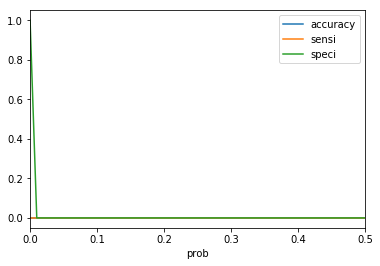

In [110]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

##### From the plot above the optimal cut off probability is 0.11

In [111]:
print(metrics.confusion_matrix( y_pred_final.churn, y_pred_final[0.12] ))

[[2669  743]
 [  27   55]]


In [112]:
print(classification_report(y_pred_final.churn,y_pred_final[0.12]))

             precision    recall  f1-score   support

          0       0.99      0.78      0.87      3412
          1       0.07      0.67      0.12        82

avg / total       0.97      0.78      0.86      3494



- This is going to be our final model with cut off probability of 0.12

# Tree models

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, test_size= 0.3)

##  Decision Tree

In [114]:
# fit model on training data with default hyperparameters
shallow_tree = DecisionTreeClassifier(max_depth=3, random_state=100)

In [115]:
shallow_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [116]:
# This will predict the the label
y_pred_dt1 = shallow_tree.predict(X_test)

#This will calculate probabilities
y_pred_dt2 = shallow_tree.predict_proba(X_test)

dt_accuracy = metrics.accuracy_score(y_test, y_pred_dt1)
dt_auc= metrics.roc_auc_score(y_test, y_pred_dt2[:,1])
print('This decision tree has accuracy rate of',dt_accuracy,'and ROC-AUC',dt_auc)

('This decision tree has accuracy rate of', 0.9742415569547797, 'and ROC-AUC', 0.7157172503069449)


In [117]:
confusion_dt = metrics.confusion_matrix( y_test, y_pred_dt1)
confusion_dt

array([[3402,    4],
       [  86,    2]])

In [118]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred_dt1))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      3406
          1       0.33      0.02      0.04        88

avg / total       0.96      0.97      0.96      3494



In [119]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot, graphviz

# Putting features
features = list(X.columns)
len(features)

159

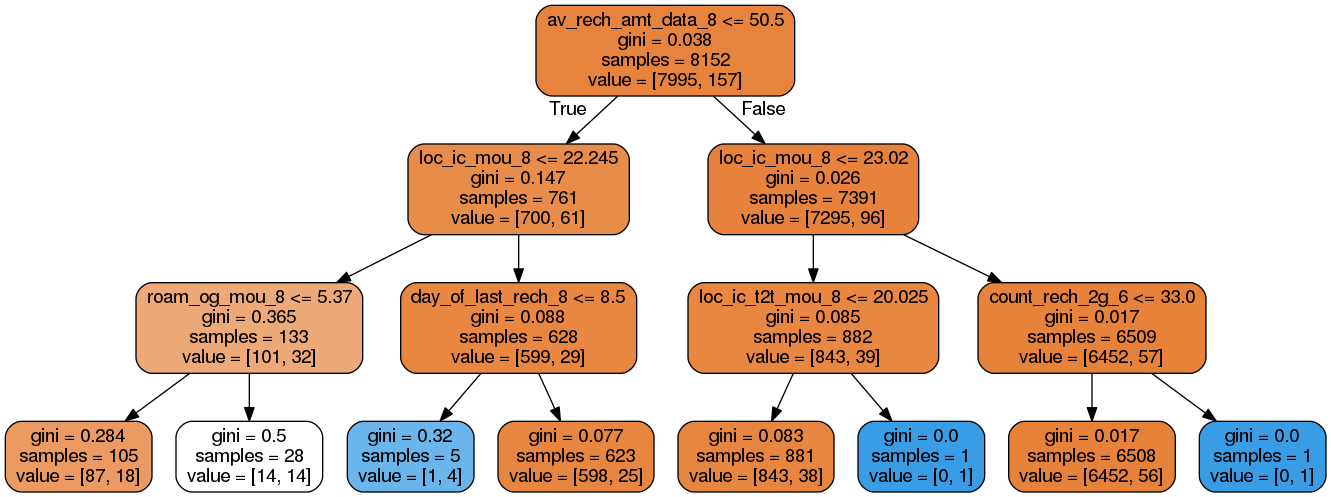

In [120]:
dot_data = StringIO()  
export_graphviz(shallow_tree, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

## Random Forest

### with default hyper-parameters

In [121]:
rfc1= RandomForestClassifier()

In [122]:
# fit
rfc1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [123]:
# This will predict the the label
y_pred_rf11 = rfc1.predict(X_test)

#This will calculate probabilities
y_pred_rf12 = rfc1.predict_proba(X_test)

rf1_accuracy = metrics.accuracy_score(y_test, y_pred_rf11)
rf1_auc= metrics.roc_auc_score(y_test, y_pred_rf12[:,1])
print('This decision tree has accuracy rate of',rf1_accuracy,'and ROC-AUC',rf1_auc)

('This decision tree has accuracy rate of', 0.9745277618775043, 'and ROC-AUC', 0.7051943762344525)


In [124]:
confusion_rf1 = metrics.confusion_matrix( y_test, y_pred_rf11)
confusion_rf1

array([[3405,    1],
       [  88,    0]])

In [125]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred_rf11))

             precision    recall  f1-score   support

          0       0.97      1.00      0.99      3406
          1       0.00      0.00      0.00        88

avg / total       0.95      0.97      0.96      3494



### Tuning hyper parameters

In [126]:
rfc2 = RandomForestClassifier(bootstrap=True,
                             max_depth=4,
                             max_features=40,
                             n_estimators=400)
#                              )

In [127]:
# fit
rfc2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=40, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [128]:
# This will predict the the label
y_pred_rf21 = rfc2.predict(X_test)

#This will calculate probabilities
y_pred_rf22 = rfc2.predict_proba(X_test)


rf2_accuracy = metrics.accuracy_score(y_test, y_pred_rf21)
rf2_auc= metrics.roc_auc_score(y_test, y_pred_rf22[:,1])
print('This random forest has accuracy rate of',rf2_accuracy,'and ROC-AUC',rf2_auc)

('This random forest has accuracy rate of', 0.9748139668002289, 'and ROC-AUC', 0.8372357604227834)


In [129]:
# Let's see th confusion matrix for this random forest
print(metrics.confusion_matrix( y_test, y_pred_rf21))

[[3406    0]
 [  88    0]]


In [130]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred_rf21))

             precision    recall  f1-score   support

          0       0.97      1.00      0.99      3406
          1       0.00      0.00      0.00        88

avg / total       0.95      0.97      0.96      3494



## AdaBoost

In [131]:
# adaboost with the shallow_tree as base estimator.
# we're using the same shallow_tree in the very beginning of decision tree model.

estimators = list(range(1, 70, 5))

abc_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(
    base_estimator=shallow_tree, 
    n_estimators = n_est)
    
    ABC.fit(X_train, y_train)
    y_pred_ab = ABC.predict_proba(X_test)
    score = metrics.roc_auc_score(y_test, y_pred_ab[:,1])
    abc_scores.append(score)

In [132]:
abc_scores

[0.7157172503069449,
 0.7998185021085784,
 0.7910789115464688,
 0.7711608525062723,
 0.7533163401484012,
 0.7115551433299525,
 0.6978560561575828,
 0.6956573960390754,
 0.6982864463780494,
 0.7056998345166283,
 0.7025569849997331,
 0.7065806331073506,
 0.7033143383334223,
 0.6964414402391501]

In [133]:
max(abc_scores)

0.7998185021085784

In [134]:
[i for i in range (1,70,5)]

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66]

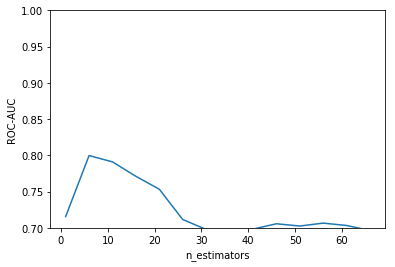

In [135]:
# plot test scores and n_estimators
# plot
plt.plot(estimators, abc_scores)
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.ylim([0.7, 1])
plt.show()

- For 11 estimators we are getting maximum ROC-AUC.
- Let's evaluate it further.

In [136]:
abc_final= AdaBoostClassifier(
    base_estimator=shallow_tree, 
    n_estimators = 6)

In [137]:
abc_final.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
          learning_rate=1.0, n_estimators=6, random_state=None)

In [138]:
# This will predict the the label
y_pred_ab1 = abc_final.predict(X_test)

#This will calculate probabilities
y_pred_ab2 = abc_final.predict_proba(X_test)


abc_accuracy = metrics.accuracy_score(y_test, y_pred_ab1)
abc_auc= metrics.roc_auc_score(y_test, y_pred_ab2[:,1])
print('This AdaBoost model gives has accuracy rate of',abc_accuracy,'and ROC-AUC',abc_auc)

('This AdaBoost model gives has accuracy rate of', 0.9753863766456783, 'and ROC-AUC', 0.7995315752949341)


In [139]:
print(metrics.confusion_matrix( y_test, y_pred_ab1))


[[3391   15]
 [  71   17]]


In [140]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred_ab1))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      3406
          1       0.53      0.19      0.28        88

avg / total       0.97      0.98      0.97      3494



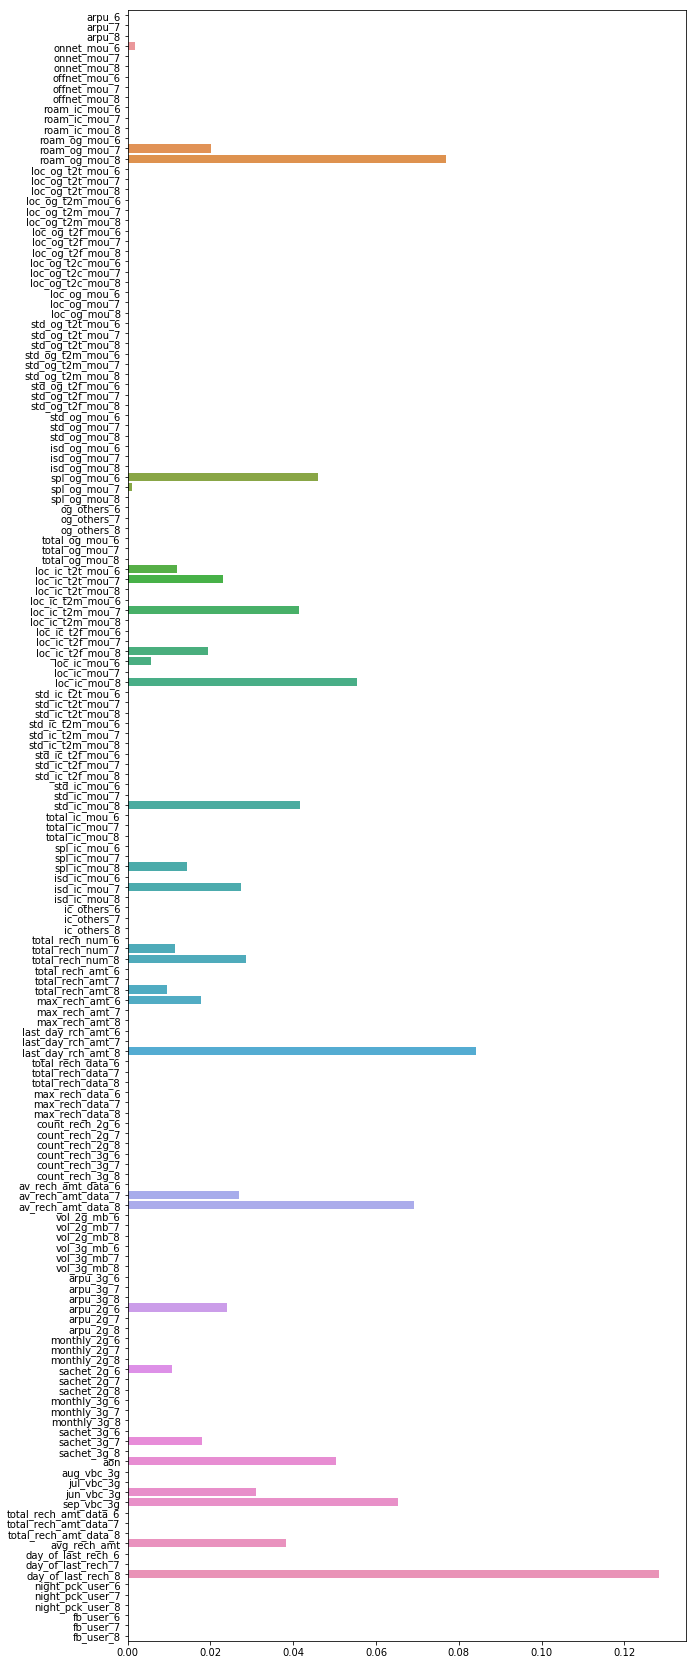

In [141]:
plt.figure(figsize=(10,30))
sns.barplot(x=abc_final.feature_importances_ ,y= X_train.columns)

### XgBoost

#### Running first model(Default hyperparameters)

In [142]:
# fit model on training data with default hyperparameters
model_xg = XGBClassifier()
model_xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [143]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred_xg1 = model_xg.predict(X_test)
y_pred_xg2 = model_xg.predict_proba(X_test)

xg_accuracy = metrics.accuracy_score(y_test, y_pred_xg1)
xg_auc= metrics.roc_auc_score(y_test, y_pred_xg2[:,1])
print('This XGBoost model gives has accuracy rate of',xg_accuracy,'and ROC-AUC',xg_auc)

('This XGBoost model gives has accuracy rate of', 0.9759587864911277, 'and ROC-AUC', 0.9050038701756259)


/home/abhi/venvs/notebook/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [144]:
print(metrics.confusion_matrix(y_test, y_pred_xg1))

[[3402    4]
 [  80    8]]


###  Grid Search to Find Optimal Hyperparameters

In [145]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.4, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=3)

# set up GridSearchCV()
xgb_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [146]:
# fit the model
xgb_cv.fit(X_train, y_train)       

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.3, 0.6, 0.9], 'learning_rate': [0.2, 0.4, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [147]:
# cv results
xg_cv_results = pd.DataFrame(xgb_cv.cv_results_)
xg_cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.027964,0.014911,0.798345,0.998851,0.2,0.3,"{u'subsample': 0.3, u'learning_rate': 0.2}",6,0.825930,0.999432,0.776079,0.998338,0.793015,0.998783,0.012369,0.000336,0.020698,0.000449
1,2.732289,0.015013,0.824964,0.999993,0.2,0.6,"{u'subsample': 0.6, u'learning_rate': 0.2}",2,0.849092,0.999996,0.806076,1.000000,0.819714,0.999982,0.045812,0.000187,0.017950,0.000008
2,2.656898,0.017772,0.834419,0.999997,0.2,0.9,"{u'subsample': 0.9, u'learning_rate': 0.2}",1,0.874169,0.999991,0.795894,1.000000,0.833179,1.000000,0.051192,0.003154,0.031969,0.000004
3,2.139936,0.015369,0.771126,0.999936,0.4,0.3,"{u'subsample': 0.3, u'learning_rate': 0.4}",8,0.789451,0.999971,0.727984,0.999932,0.795937,0.999905,0.036843,0.000464,0.030618,0.000027
4,2.733847,0.015346,0.804427,1.000000,0.4,0.6,"{u'subsample': 0.6, u'learning_rate': 0.4}",5,0.829998,1.000000,0.788375,1.000000,0.794898,1.000000,0.068769,0.000122,0.018280,0.000000
5,2.559544,0.015622,0.819709,1.000000,0.4,0.9,"{u'subsample': 0.9, u'learning_rate': 0.4}",3,0.872831,1.000000,0.778648,1.000000,0.807627,1.000000,0.011672,0.000237,0.039389,0.000000
6,1.992115,0.015865,0.753770,0.999814,0.6,0.3,"{u'subsample': 0.3, u'learning_rate': 0.6}",9,0.806457,0.999493,0.694891,0.999959,0.759944,0.999989,0.019127,0.000674,0.045757,0.000227
7,2.601638,0.015037,0.776231,1.000000,0.6,0.6,"{u'subsample': 0.6, u'learning_rate': 0.6}",7,0.816843,1.000000,0.745144,1.000000,0.766691,1.000000,0.006248,0.000084,0.030039,0.000000
8,2.440647,0.015351,0.809194,1.000000,0.6,0.9,"{u'subsample': 0.9, u'learning_rate': 0.6}",4,0.870870,1.000000,0.756278,1.000000,0.800411,1.000000,0.027768,0.000277,0.047194,0.000000


In [148]:
print('We can get ROC_AUC of',xgb_cv.best_score_,'using',xgb_cv.best_params_)

('We can get ROC_AUC of', 0.8344190288671147, 'using', {'subsample': 0.9, 'learning_rate': 0.2})


In [149]:
xg_cv_results['param_learning_rate'] = xg_cv_results['param_learning_rate'].astype('float')


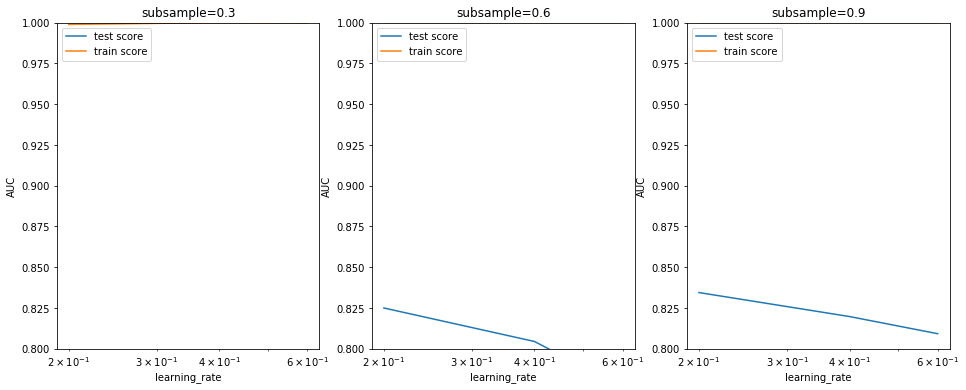

In [150]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.4, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = xg_cv_results[xg_cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.8, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

#### Selecting hyperparameters from above plots as: learning_rate=0.2, subsample=0.6

In [151]:
params = {'learning_rate': 0.2,
          'max_depth': 3, 
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
xg_final = XGBClassifier(params = params)
xg_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       params={'objective': 'binary:logistic', 'subsample': 0.6, 'learning_rate': 0.2, 'max_depth': 3},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [152]:
#AUC score
# predict
y_pred_xgb1 = xg_final.predict(X_test)
y_pred_xgb2 = xg_final.predict_proba(X_test)

xg_final_accuracy = metrics.accuracy_score(y_test, y_pred_xgb1)
xg_final_auc = metrics.roc_auc_score(y_test, y_pred_xgb2[:,1])

print('This XGBoost model gives has accuracy rate of',xg_final_accuracy,'and ROC-AUC',xg_final_auc)

('This XGBoost model gives has accuracy rate of', 0.9759587864911277, 'and ROC-AUC', 0.9050038701756259)


/home/abhi/venvs/notebook/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [153]:
# Confusion matrix 
print(metrics.confusion_matrix( y_test, y_pred_xgb1))

[[3402    4]
 [  80    8]]


In [154]:
print(classification_report(y_test, y_pred_xgb1))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      3406
          1       0.67      0.09      0.16        88

avg / total       0.97      0.98      0.97      3494



In [155]:
importance = dict(zip(X_train.columns, xg_final.feature_importances_))

imp_gain= xg_final.get_booster().get_score(importance_type='gain')
# gain_val = list(imp_gain.values())

imp_weight= xg_final.get_booster().get_score(importance_type='weight')
# weight_val = list(imp_weight.values())

imp_cover= xg_final.get_booster().get_score(importance_type='cover')
# cover_val = list(imp_cover.values())

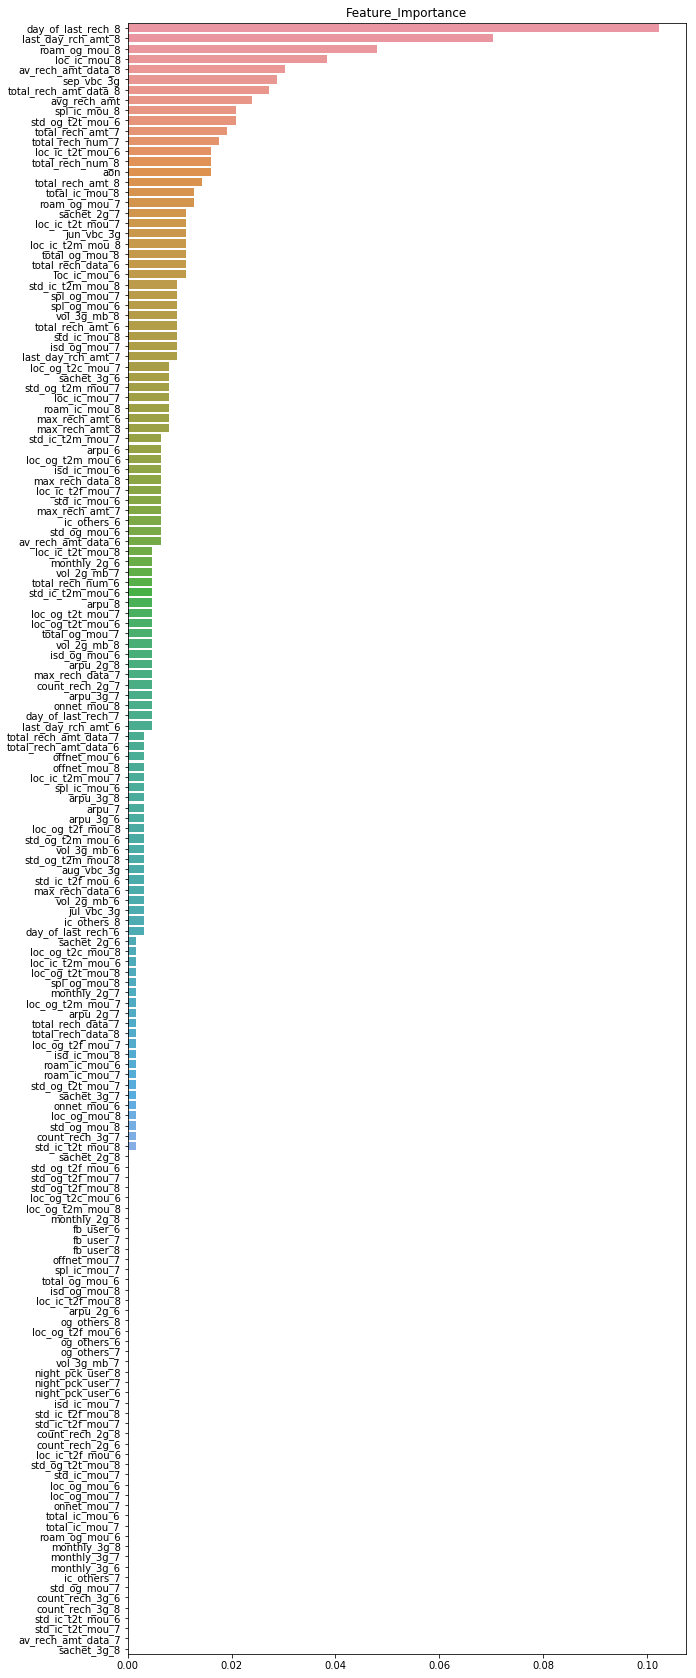

In [156]:
impt_data= sorted(importance.items(), key=lambda x:x[1], reverse=True)
xi_val = [xi[0] for xi in impt_data]
yi_val = [xi[1] for xi in impt_data]
plt.figure(figsize=(10,30))
plt.title('Feature_Importance')
sns.barplot(y= xi_val, x=yi_val)

In [157]:
impt_data[0:10]

[('day_of_last_rech_8', 0.10223642),
 ('last_day_rch_amt_8', 0.07028754),
 ('roam_og_mou_8', 0.047923323),
 ('loc_ic_mou_8', 0.038338657),
 ('av_rech_amt_data_8', 0.030351438),
 ('sep_vbc_3g', 0.028753994),
 ('total_rech_amt_data_8', 0.02715655),
 ('avg_rech_amt', 0.023961661),
 ('spl_ic_mou_8', 0.020766772),
 ('std_og_t2t_mou_6', 0.020766772)]

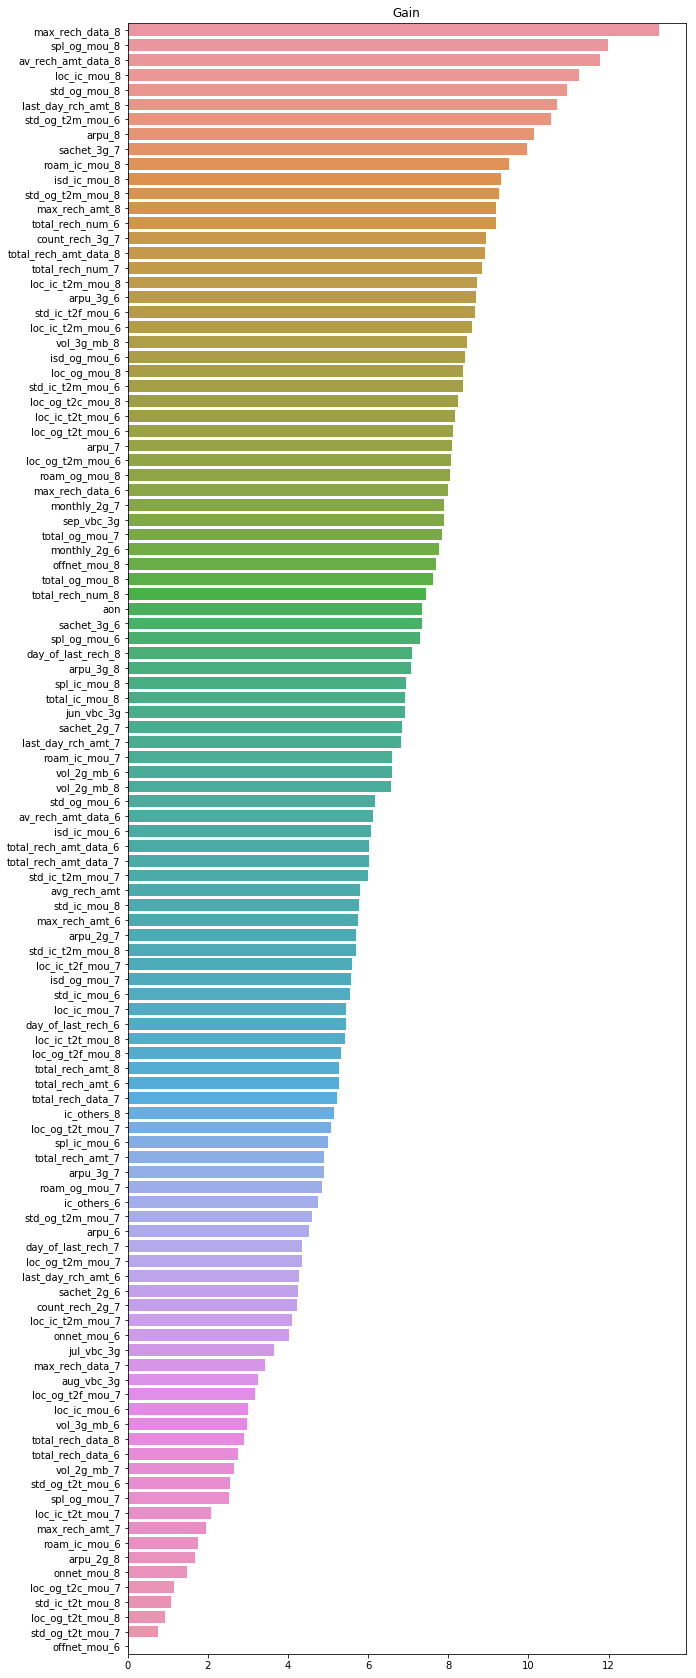

In [158]:
gain_data= sorted(imp_gain.items(), key=lambda x:x[1], reverse=True)
xg_val = [xg[0] for xg in gain_data]
yg_val = [xg[1] for xg in gain_data]
plt.figure(figsize=(10,30))
plt.title('Gain')
# sns.barplot(y= list(imp_gain.keys()),x= gain_val)
sns.barplot(y= xg_val, x=yg_val)

In [159]:
gain_data

[('max_rech_data_8', 13.259715325),
 ('spl_og_mou_8', 11.9752979),
 ('av_rech_amt_data_8', 11.793833902631581),
 ('loc_ic_mou_8', 11.25734355191667),
 ('std_og_mou_8', 10.963192),
 ('last_day_rch_amt_8', 10.710101890022726),
 ('std_og_t2m_mou_6', 10.562536699999999),
 ('arpu_8', 10.141280633333333),
 ('sachet_3g_7', 9.96638393),
 ('roam_ic_mou_8', 9.527739332),
 ('isd_ic_mou_8', 9.32691574),
 ('std_og_t2m_mou_8', 9.26705599),
 ('max_rech_amt_8', 9.198176344),
 ('total_rech_num_6', 9.191282913333334),
 ('count_rech_3g_7', 8.95250893),
 ('total_rech_amt_data_8', 8.90742211352941),
 ('total_rech_num_7', 8.835654476363635),
 ('loc_ic_t2m_mou_8', 8.713229864285713),
 ('arpu_3g_6', 8.692210195),
 ('std_ic_t2f_mou_6', 8.66862251),
 ('loc_ic_t2m_mou_6', 8.5903368),
 ('vol_3g_mb_8', 8.462723565),
 ('isd_og_mou_6', 8.424723003333334),
 ('loc_og_mou_8', 8.37476444),
 ('std_ic_t2m_mou_6', 8.362557246666666),
 ('loc_og_t2c_mou_8', 8.23805714),
 ('loc_ic_t2t_mou_6', 8.180306754),
 ('loc_og_t2t_mou_6

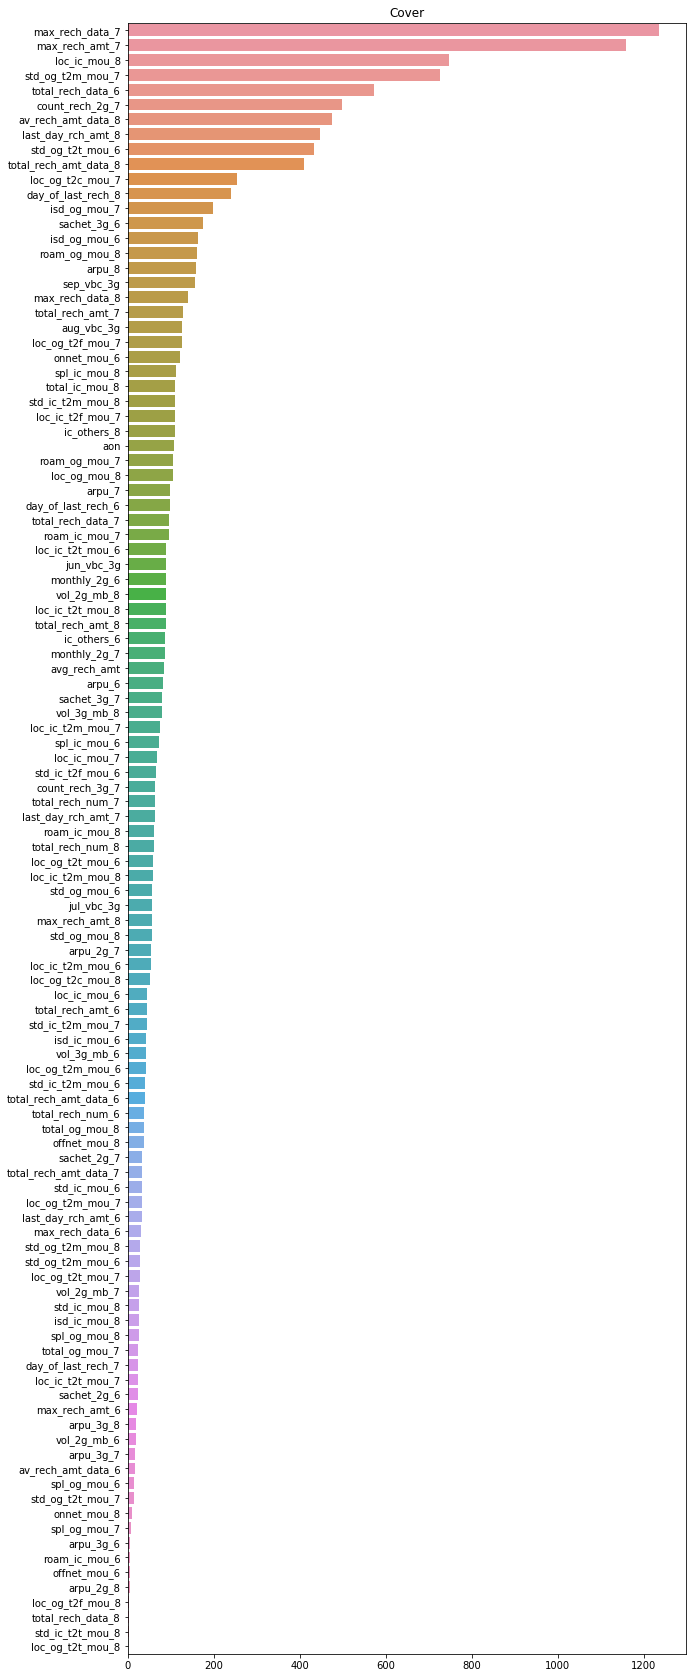

In [160]:
cover_data= sorted(imp_cover.items(), key=lambda x:x[1], reverse=True)
xc_val = [xc[0] for xc in cover_data]
yc_val = [xc[1] for xc in cover_data]
plt.figure(figsize=(10,30))
plt.title('Cover')
# sns.barplot(y= list(imp_cover.keys()),x= weight_val)
sns.barplot(y= xc_val, x=yc_val)

# Report

- __Our predictive model with PCA and logistic regression managed to find churners correctly 82 percent of the time while maintaining overall model accuracy at 81.61 percent at cut-off probability of 0.12.__

- To identify important driving factors, we trained various tree models and among those we are choosing XgBoost and it has necessary metrics associated with it to give clear insight.

#### Feature Importance:
__model.feature_importances__ tells us importance of a feature in generating the prediction. Higher the value more important is the feature in determining the prediction.(in our case which customer is going to churn). When we implemented this on our xg_final model we got following top 10 important features:
- 'day_of_last_rech_8', 'roam_og_mou_8', 'last_day_rch_amt_8', 'total_ic_mou_8', 'sep_vbc_3g', 'av_rech_amt_data_8', 'loc_ic_mou_8', 'aon', 'avg_rech', 'roam_og_mou_7'.

__model gain__ The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.
- 'total_ic_mou_8', 'loc_ic_mou_8', 'fb_user_8', 'av_rech_amt_data_8', 'total_rech_amt_data_8', 'last_day_rch_amt_8', 'std_og_mou_7', 'roam_og_mou_8', 'loc_og_t2f_mou_8', 'total_rech_num_7'.


## Observations and inferences:
- 6th and 7th month are good phase and 8th month is action phase

- If a customer shows reduction in total incoming calls minutes of usage(total_ic_mou_8) and local incoming calls minutes of usage(loc_ic_mou_8) in action phase to 0 or less than average value of good months, then he/she is most likely to churn in churn phase.
##### Therefore if we want to reduce the churn rate then it's very important to target customers for whome total incoming minutes of usge and local incoming minutes of usage is 0 or less than average of good phase(average: (total_ic_mou_6+total_ic_mou_7)/2 ) in action phase that is 8th  month.

- Also the customers who are going to churn show significant reduction in _average recharge amount data_ in action phase compare to customers who have not churned in action phase. 
##### Therefore from EDA section, customers who show less  average  recharge amount data in action phase(av_rech_amt_data_8) compare to 6th and 7th month should be targeted for less churning rate.

- Last day recharge amount of action phase (last_day_rch_amt_8) is also a important indicator. Interestingly customers who are going to churn show 0 or less than average last day recharge amount not only for 8th month but also for 7th month.(plot from EDA section).
##### Therefore to target customers based on last_day_rch_amt_, we can  look at both last_day_rch_amt_7 and last_day_rch_amt_8 as most of those who are going to churn later show similar behaviour  on the last day recharge amount of 7th and 8th month.

- From the barplot in EDA, customers who are going to churn show small reduction in total recharge amount data 7 compare total recharge amount data 7 but huge fall from total recharge amount data 7 to total recharge amount data 8.

###### From the groupby tables in EDA section, customers for whome last day of recharge has shifted to the first week are very likely to churn. As we can see in the customers with label 1 are less in the the first week of 6th and 7th month but are relatively large in 8th month.


###### Customers who are going to churn also show significant drop in std outgoing minutes of usage in 8th month compare to 6th and 7th month 